## Table of Contents:
* [Introduction](#Introduction)
* [Import Libraries](#import-libraries)
* [Unpickling the dictionary](#unpickle)
* [How Stock price relates to exogenous variables](#best)
* [High momentum stock list](#momentum)


## Introduction <a class="anchor" id="Introduction"></a>

## Exploratory Data Analysis

In this notebook, we have carried out exploratory data analysis of stock price data. We have explore the effect of exogenous variables 
on stock price for eack of the company. Finally, we have pulled high momentum stocks for one, five and ten years investment.

## Importing the necessary libraries <a class="anchor" id="import-libraries"></a>

In [157]:
import pandas as pd
import pandas
import datetime as dt
from datetime import datetime
from urllib.error import HTTPError
#import requests
#from bs4 import BeautifulSoup
import re
import csv
import numpy as np
import warnings
from sklearn import datasets, linear_model, metrics
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

## Unpickling the data<a class="anchor" id="unpickle"></a>

In [252]:
with open('materials_ticker_dfs_qtly.pickle', 'rb') as handle:
    materials_ticker_dfs_qtly = pickle.load(handle)

with open('materials_ticker_dfs_daily.pickle', 'rb') as handle:
    materials_ticker_dfs_daily = pickle.load(handle)
    
with open('ticker_sector_wise.pickle', 'rb') as handle:
    ticker_sector_wise = pickle.load(handle)



In [253]:
ticker_sector_wise

,Ticker,Company_Name\r,sector,txt_file,Unnamed: 0
0,aty,AcuityAds Holdings Inc\r,communication_service_ticker_dfs,Data/generated/daily/aty.csv,NaN
1,adv,Advantage Solutions Inc. - Class A\r,communication_service_ticker_dfs,Data/generated/daily/adv.csv,NaN
2,mimo,Airspan Networks Holdings Inc\r,communication_service_ticker_dfs,Data/generated/daily/mimo.csv,NaN
3,goog,Alphabet Inc\r,communication_service_ticker_dfs,Data/generated/daily/goog.csv,NaN
4,googl,Alphabet Inc\r,communication_service_ticker_dfs,Data/generated/daily/googl.csv,NaN
...,...,...,...,...,...
61,via,Via Renewables Inc - Class A\r,utility_ticker_dfs,Data/generated/daily/via.csv,NaN
62,vwtr,Vidler Water Resources Inc\r,utility_ticker_dfs,Data/generated/daily/vwtr.csv,NaN
63,vst,Vistra Energy Corp\r,utility_ticker_dfs,Data/generated/daily/vst.csv,NaN
64,xel,Xcel Energy Inc\r,utility_ticker_dfs,Data/generated/daily/xel.csv,NaN


,date,close,daily_returns
0,2012-01-03,22.291,0.004597
1,2012-01-04,22.323,0.001436
2,2012-01-05,22.308,-0.000672
3,2012-01-06,22.100,-0.009324
4,2012-01-09,22.085,-0.000679
...,...,...,...
1471,2017-11-06,32.860,-0.013213
1472,2017-11-07,33.070,0.006391
1473,2017-11-08,33.440,0.011188
1474,2017-11-09,34.000,0.016746


## How Stock price relates to exogenous variables<a class="anchor" id="best"></a>


In [167]:
missing_revenue = []
company_model = pd.DataFrame(columns = ['Company','Model', 'Daily_Returns', 'Revenue_Amount', 'PE Ratio',
                                        'Interest Rate','RMSE'])
#company_model = pd.DataFrame(columns = ['Company','Model'])
warnings.filterwarnings("ignore", category=FutureWarning)

def best_model(company_df, company_model):
    
    kf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    X = company_df[company_df.columns[3:]].values#.reshape((-1,1))
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y = company_df[company_df.columns[2]].values.reshape((-1,1))
        
    try:
        #Linearregression
        model_lin = LinearRegression()
        Linear_reg_CV_score = np.mean(cross_val_score(model_lin, X_scaled, y, scoring='neg_mean_squared_error', cv=kf))
            
        #Ridgeregression
            #ridge = RidgeCV(cv=10).fit(X, y)
            #Ridge_reg_CV_score = ridge.score(X, y)
        model_ridge = Ridge()
        Ridge_reg_CV_score = np.mean(cross_val_score(model_ridge, X_scaled, y, scoring='neg_mean_squared_error', cv=kf))
        
        #Lassoregression
            #lasso = LassoCV(cv=10).fit(X, y)
            #Lasso_reg_CV_score = lasso.score(X, y)
        model_lasso = Lasso()
        Lasso_reg_CV_score = np.mean(cross_val_score(model_lasso, X_scaled, y, scoring='neg_mean_squared_error', cv=kf))
        #polynomialregression
        poly = PolynomialFeatures(degree=2, include_bias=True)
        x_train_trans = poly.fit_transform(X_scaled)
        PolyLinear_reg_CV_score  = np.mean(cross_val_score(model_lin, x_train_trans, y, cv=kf, scoring='neg_mean_squared_error'))
        
        #ElasticNet
        ratios = arange(0, 1, 0.01)
        elastic_net = ElasticNetCV(l1_ratio=ratios)
        Elastic_Net_CV_score = np.mean(cross_val_score(elastic_net, X_scaled, y, scoring='neg_mean_squared_error', cv=kf))
        
    except ValueError:
        missing_revenue.append(company_df['Ticker'])
        return None   
    
    CV_scores = {'Linear Regression': Linear_reg_CV_score, 'Ridge Regression': Ridge_reg_CV_score, 'Lasso Regression': Lasso_reg_CV_score,'Polynomial Regression':PolyLinear_reg_CV_score,
                'Elastic Net': Elastic_Net_CV_score}
    
    max_score = float('-inf')
    best_model = None
    for models in CV_scores:
        if (max_score < CV_scores[models]):
            max_score = CV_scores[models]
            best_model = models
    
    company_model = company_model.append({'Company': company_df['Ticker'].values[0], 'Model': best_model}, ignore_index = True)
    
    
    train_model = {'Linear Regression': LinearRegression(), 'Ridge Regression': Ridge(), 'Lasso Regression': Lasso(),
                  'Elastic Net': ElasticNet(alpha=1.0, l1_ratio=0.5)}
    
    model = train_model[best_model].fit(X_scaled, y)
    print (best_model)
    coef_val = model.coef_[0]
    print (coef_val)
    
    #company_model = company_model.append({'Company': company_df['Ticker'].values[0], 'Model': best_model, 
    #                                      'Daily_Returns': coef_val[0], 'Revenue_Amount':coef_val[1], 'PE Ratio': coef_val[2],
    #                                      'Interest Rate':coef_val[3] ,'RMSE': np.sqrt(-max_score)}, ignore_index = True) 
    
    #return company_model
    
    
   
        

#best_model_dict = best_model(exo_df)

#print (best_model_dict)


company_model_df = materials_ticker_dfs_qtly.groupby('Ticker').apply(best_model, company_model=company_model)


Linear Regression
[0.47506845 2.51658424 1.27909357 3.53427723]
Lasso Regression
0.0
Linear Regression
[-0.19083251  0.22574452  2.11462894  0.4766281 ]
Elastic Net
-0.0
Elastic Net
-0.0
Lasso Regression
-0.0
Ridge Regression
[ -6.4309377   10.89912512   0.         -23.74407795]
Lasso Regression
-0.0
Elastic Net
-1.3071618927561022
Lasso Regression
0.0
Elastic Net
-0.0
Ridge Regression
[ 0.19838195  1.55855308  0.         -0.42593086]
Ridge Regression
[-0.04614535  0.64504964  3.26599281 -1.09943499]
Ridge Regression
[-0.3468295   3.1905951  -2.92640904 -1.49649243]
Ridge Regression
[0.03495177 1.18236311 0.50293733 0.2520757 ]
Linear Regression
[0.65883637 1.29695772 0.9765376  5.22999407]
Ridge Regression
[-1.71031038  6.18840575  6.2134408   6.20551448]
Lasso Regression
-0.0
Lasso Regression
-0.0
Ridge Regression
[-2.23727127  5.13198114 12.92364123 13.96650911]
Elastic Net
-0.02350899750743886
Lasso Regression
0.22381101517661328
Ridge Regression
[1.10540282 4.0362873  1.04665203 1

In [161]:

#cmpny_model = pd.DataFrame(columns = ['Company','Model'])
#cmpny_model = cmpny_model.append({'Company': 'aa', 'Model': 'Love'}, ignore_index = True)

aa = materials_ticker_dfs_qtly[materials_ticker_dfs_qtly['Ticker'] == 'aa']
aa_X = aa[aa.columns[3:]].values
aa_y = aa[aa.columns[2]].values.reshape((-1,1))
#company_model_df#[company_model_df['Model'] == 'Lasso Regression']
model_lin = LinearRegression()
#Linear_reg_CV_score = (cross_val_score(model_lin, aa_X, aa_y, scoring='', cv=5))
fit_lin = model_lin.fit(aa_X, aa_y)
pre_y = fit_lin.predict(aa_X)
mse = ((pre_y-aa_y)**2)

company_model_df
#model_df.nsmallest(n = 5, columns = 'RMSE')
#co = fit_lin.coef_[0]


,,Company,Model
Ticker,,,
aa,0,aa,Linear Regression
aau,0,aau,Lasso Regression
ach,0,ach,Linear Regression
aem,0,aem,Elastic Net
ag,0,ag,Elastic Net
...,...,...,...
wlk,0,wlk,Elastic Net
wpm,0,wpm,Ridge Regression
x,0,x,Elastic Net


In [ ]:
def train_best_model(df):
 




    
    
materials_ticker_dfs_qtly.groupby('Ticker', group_keys = False).apply(train_best_model, company_model=company_model)


In [ ]:
score_list_dict = {}
for keys in best_model_dict:
    if best_model_dict[keys][0] not in score_list_dict:
        score_list_dict[best_model_dict[keys][0]] = [keys]
    else:
        score_list_dict[best_model_dict[keys][0]].append(keys) 

final_model_dict = {}
cols = ['Company', 'Revenue(Million $)', 'PE Ratio']

def nameToModelLookup(modelName):
    if method == 'Lasso Regression':
        return Lasso()
    if method == 'Ridge Regression':
        return Ridge()
    if method == 'Linear Regression':
        return LinearRegression()
    return None

for keys in sorted(score_list_dict.keys(), reverse = True):#[:25]:
    company, method = ((score_list_dict[keys][0]), best_model_dict[score_list_dict[keys][0]][1])
    X = exo_df[company][exo_df[company].columns[1:3]]
    y = exo_df[company][exo_df[company].columns[0]]
    if nameToModelLookup(method):
        if not method in final_model_dict:
            final_model_dict[method] = pd.DataFrame(columns = cols)
        model = nameToModelLookup(method)
        model.fit(X,y)
        coef_val = model.coef_
        final_model_dict[method] = final_model_dict[method].append({'Company':company,'Revenue(Million $)': coef_val[0],
                                                'PE Ratio' : coef_val[1]}, ignore_index = True)
    
            
final_model_dict 

In [4]:
ind = [i for i in range(1,50)]
final = pd.DataFrame(columns = ['Model','Company','Revenue(Million $)','PE Ratio'])
for keys in final_model_dict:
    final_model_dict[keys]['Model'] = keys
    final = final.append(final_model_dict[keys])
    
final.reset_index(drop = True).head(11)

,Model,Company,Revenue(Million $),PE Ratio
0,Ridge Regression,TXRH,0.099845,0.488046
1,Ridge Regression,SBUX,0.015331,0.650453
2,Ridge Regression,KMX,0.017691,1.444918
3,Ridge Regression,PAG,0.011968,1.623594
4,Ridge Regression,LOW,0.005876,3.396839
5,Ridge Regression,PII,0.124313,-1.250553
6,Ridge Regression,AZO,0.289432,54.235738
7,Ridge Regression,EAT,0.179223,2.850688
8,Ridge Regression,CCK,0.035789,0.976708
9,Lasso Regression,PZZA,0.293824,0.772794


## High momentum stock list <a class="anchor" id="momentum"></a>

In [6]:
hqm_ind = ['ticker',
        "one year price return",
        "one year return percentile",
        "five year price return",
        "five year return percentile",
        "ten year price return",
        "ten year return percentile",
          ]

year_list = ['one', 'five', 'ten']
hqm_score = pd.DataFrame(columns = hqm_ind)
for keys in cons_cyc_df_years:
    high_momntm_df = cons_cyc_df_years[keys].loc[:,(cons_cyc_df_years[keys].columns == 'Close')]
    one_year_return = high_momntm_df.asfreq('1Y', method = 'ffill').pct_change().dropna().mean().squeeze()
    five_year_return = high_momntm_df.asfreq('5Y', method = 'ffill').pct_change().dropna().mean().squeeze()
    ten_year_return = high_momntm_df.asfreq('10Y', method = 'ffill').pct_change().dropna().mean().squeeze()
    hqm_score = hqm_score.append({'ticker':keys, "one year price return":one_year_return,"one year return percentile": None, "five year price return": five_year_return, "five year return percentile" :None,"ten year price return":ten_year_return, "ten year return percentile":None}, ignore_index = True)


for rows in hqm_score.index:
    for year in year_list:
        hqm_score.loc[rows,'{} year return percentile'.format(year)] = stats.percentileofscore(hqm_score['{} year price return'.format(year)], 
                                                                              hqm_score.loc[rows,'{} year price return'.format(year)]) 

#alternate way to calculate percentile   
#hqm_score['one year return percentile'] = hqm_score['one year price return'].rank(pct = True)



hqm_score

,ticker,one year price return,one year return percentile,five year price return,five year return percentile,ten year price return,ten year return percentile
0,AAN,0.082398,19.607843,0.304979,33.333333,0.695209,47.058824
1,ANF,-0.051728,2.614379,-0.505350,0.653595,-0.800787,1.960784
2,AAP,0.193770,64.705882,1.210390,78.431373,3.825812,89.542484
3,AIN,0.124032,35.294118,0.462518,39.869281,0.585392,43.137255
4,AMZN,0.492866,97.385621,3.359363,99.346405,18.003294,100.0
...,...,...,...,...,...,...,...
148,URBN,0.107913,28.104575,0.115041,18.954248,0.236648,32.679739
149,MTN,0.197819,67.320261,1.561267,85.620915,2.980602,84.313725
150,WWW,0.093025,22.875817,0.282632,30.718954,0.644867,45.098039
151,WYNN,0.160132,48.366013,0.228410,24.836601,0.440603,37.908497


In [14]:
hqm_score_10 = hqm_score.sort_values('one year return percentile', ascending = False, ignore_index = True)[:10]
hqm_score_10


,ticker,one year price return,one year return percentile,five year price return,five year return percentile,ten year price return,ten year return percentile
0,KIRK,0.695917,100.0,0.942468,69.281046,2.273326,74.509804
1,TEN,0.618548,99.346405,0.651224,52.287582,1.527101,65.359477
2,CULP,0.553127,98.69281,2.297690,96.732026,7.174029,96.732026
3,MED,0.500701,98.039216,1.123123,76.470588,2.443469,78.431373
4,AMZN,0.492866,97.385621,3.359363,99.346405,18.003294,100.0
5,ESCA,0.440976,96.732026,1.025111,73.856209,0.581413,42.48366
6,RICK,0.419624,96.078431,0.638352,50.980392,1.520094,64.705882
7,LZB,0.408867,95.424837,0.872221,64.705882,1.749440,67.973856
8,DPZ,0.399587,94.771242,2.699532,98.69281,10.065230,98.69281
9,EXPE,0.392397,94.117647,1.724262,89.542484,4.663614,91.503268


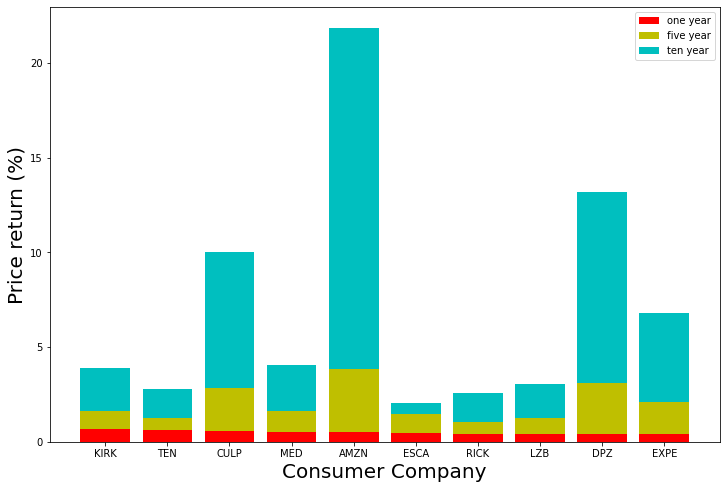

In [80]:
fig = plt.subplots(figsize =(12, 8))
plt.bar(x = hqm_score_10['ticker'], height = hqm_score_10['one year price return'], color = 'r', label = 'one year')
plt.bar(x = hqm_score_10['ticker'], height = hqm_score_10['five year price return'], label ='five year', bottom = hqm_score_10['one year price return'], color = 'y' )
plt.bar(x = hqm_score_10['ticker'], height = hqm_score_10['ten year price return'], label = 'ten year', bottom = hqm_score_10['one year price return'] + hqm_score_10['five year price return'], color = 'c')
plt.xlabel('Consumer Company', size = 20)
plt.ylabel('Price return (%)', size = 20)
plt.legend()

In [477]:
def handle_company_df(text_file):
    try:
        df = pd.read_csv(text_file)
        df['year'] = df['date'].astype('datetime64').dt.year
    except FileNotFoundError:
        pass
        return None
    df['Ticker'] = text_file.split('/')[-1].split('.')[0]
    fin_df = df.groupby(['year','Ticker'])['close'].mean().to_frame().reset_index().pivot(index='Ticker', columns='year', values='close')
    return fin_df
final_df_sector = pd.DataFrame()

def sector_wise_dfs(df):
    df_cmpny = df['txt_file'].apply(handle_company_df)
    df_cmpny.dropna(inplace = True)
    df_cmpny = df_cmpny.apply(lambda x: x.squeeze())
    return df_cmpny
    


"\nmat_yrs_close.diff(axis = 1).mean().fillna(0).plot(label = 'overall')\nmat_top_25 = mat_yrs_close.sort_values(2012, ascending = False).head(25)\n#mat_top_25.diff(axis = 1).mean().fillna(0).plot(label = 'top25')\nmat_yrs_close\n"

In [478]:
sec_wise_close = ticker_sector_wise.groupby('sector').apply(sector_wise_dfs)

In [528]:
sec_wise_close

year                                       2012        2013        2014  \
sector                                                                    
communication_service_ticker_dfs 4   321.408480  442.121111  567.960833   
                                 6    43.303192   63.873008   63.912103   
                                 7    21.850300   19.178889   20.121357   
                                 8    13.229400   19.091667   10.255913   
                                 11   25.689784   28.255560   29.056294   
...                                         ...         ...         ...   
utility_ticker_dfs               58   12.289912   10.979115    9.479374   
                                 59   17.322728   23.403075   30.442464   
                                 60   21.640836   24.721484   29.238464   
                                 61   46.648020   65.996512   75.160266   
                                 64   22.574600   24.593540   27.871976   

year                                       2015        2016        2017  
sector                                                                   
communication_service_ticker_dfs 4   619.988929  763.213722  922.925688  
                                 6    75.290893   59.618690   57.087202  
                                 7    18.016710   12.338988   15.593303  
                                 8     6.380595    8.543631    9.839540  
                                 11   29.990647   36.753587   38.012330  
...                                         ...         ...         ...  
utility_ticker_dfs               58    6.276747    4.467065    5.814128  
                                 59   33.247599   41.148290   48.169280  
                                 60   32.471710   39.130802   47.562422  
                                 61   55.439099   42.640131   40.014853  
                                 64   32.155599   39.120540   45.438679  

[1613 rows x 6 columns]

In [616]:
def sec_wise_plot(df):
    df = df.diff(axis = 1).fillna(0)
    df = df.mean()
    return df
    
sector_plot = sec_wise_close.groupby('sector').apply(sec_wise_plot)

In [617]:
sector_plot.index = sector_plot.index.str.title()#.str.split('_Ticker')[0]
sector_plot.index = sector_plot.index.str.split('_Ticker').map(lambda x: x[0] + '_Sector')
sector_plot

year,2012,2013,2014,2015,2016,2017
sector,,,,,,
Communication_Service_Sector,0.0,6.957531,6.486674,3.694178,2.338263,9.861301
Consumer_Cyclical_Sector,0.0,9.197429,8.207993,6.670192,-0.022657,6.607322
Consumer_Defensive_Sector,0.0,9.786706,6.373408,7.752894,2.045350,5.847132
Energy_Sector,0.0,4.981260,2.764639,-15.274992,-7.309611,2.366162
Financial_Sector,0.0,7.141518,4.795222,2.229081,2.270450,10.949199
Healthcare_Sector,0.0,-0.578754,9.221626,3.446496,-7.278615,6.398397
Industrial_Sector,0.0,-342.653836,-4427.878043,-2987.912749,-549.134575,-156.643966
Materials_Sector,0.0,-5.943082,1.553377,-2.943494,1.192833,7.092122
Technology_Sector,0.0,3.215242,4.694668,3.137182,0.462613,7.730350


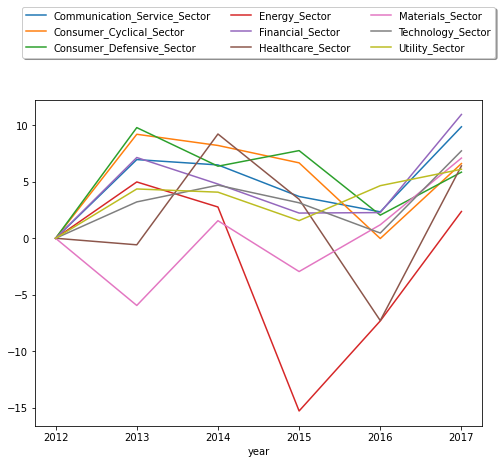

In [618]:
sector_plot.drop('Industrial_Sector').T.plot(figsize=(8, 6))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.30),
          ncol=3, fancybox=True, shadow=True)
plt.show()